In [35]:
import investpy as ipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
import seaborn as sns
from scipy.stats import skew,kurtosis,jarque_bera
from scipy.optimize import minimize

In [3]:
tickers = ['ADBE','EPAM','FB','INTU','MSFT','NVDA','PYPL']

In [4]:
def get_return(tickers:list,start_data:str,end_date:str)->pd.DataFrame:
    agg_dataframe = pd.DataFrame()
    for ticker in tickers:
        data = ipy.get_stock_historical_data(stock=ticker,country='United States',from_date=start_data,to_date=end_date)
        agg_dataframe[ticker] = data['Close']
    daily_returns = agg_dataframe.pct_change()
    daily_returns = daily_returns.dropna()
    return (daily_returns,agg_dataframe)

In [5]:
returns,data = get_return(tickers,'01/01/2010','12/08/2021')

In [6]:
data_mon = data.resample('M').last()

<AxesSubplot:>

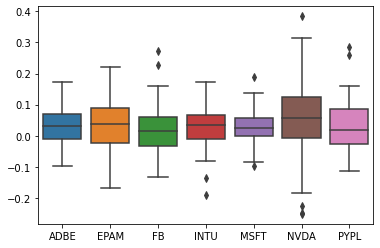

In [37]:
sns.boxplot(data=return_mon)

In [7]:
return_mon = data_mon.pct_change().dropna()



In [50]:
def annualized_stock_return(data):
        return (1+data).prod()**(12/data.shape[0])-1

In [51]:
def annualized_stock_volatility(data):
        return data.std()*sqrt(12)


In [52]:
annualized_stock_return(return_mon)

ADBE    0.399800
EPAM    0.411052
FB      0.248476
INTU    0.306112
MSFT    0.349966
NVDA    0.832970
PYPL    0.380022
dtype: float64

In [53]:

annualized_stock_volatility(return_mon)

ADBE    0.218463
EPAM    0.273347
FB      0.268551
INTU    0.222206
MSFT    0.186829
NVDA    0.416429
PYPL    0.268792
dtype: float64

# Risk/Ruturn Ratios

## Sharpe Ratio

In [20]:
def sharpe_ratio(data,free_rate=0.1):
    return (annualized_stock_return(data)-free_rate)/annualized_stock_volatility(data)
sharpe_ratio(return_mon)

ADBE    1.372312
EPAM    1.137938
FB      0.552881
INTU    0.927571
MSFT    1.337939
NVDA    1.760130
PYPL    1.041780
dtype: float64

## Sortino ratio

In [30]:
def semidiviation(data):
    return data[data<0].std()*sqrt(12)


In [28]:
def sortino_ratio(data,free_rate=0.1):
    return (annualized_stock_return(data)-free_rate)/semidiviation(data)

In [31]:
sortino_ratio(return_mon)

ADBE    3.079520
EPAM    1.946273
FB      1.169404
INTU    1.342542
MSFT    2.389018
NVDA    2.593484
PYPL    2.667482
dtype: float64

## Calmar Ratio 

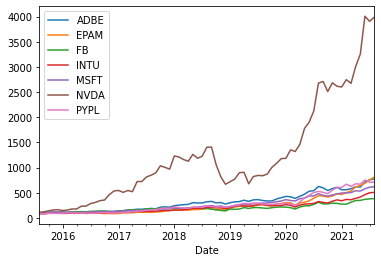

In [41]:
WI = 100*(1+return_mon).cumprod() -1
pl =WI.plot()


In [48]:
peaks = WI.cummax()
drawdown = (WI-peaks)/peaks
-drawdown.min()

ADBE    0.162412
EPAM    0.189326
FB      0.326973
INTU    0.203131
MSFT    0.112376
NVDA    0.525213
PYPL    0.164105
dtype: float64

In [49]:
calmar_ratio=annualized_stock_return(return_mon)/-drawdown.min()
calmar_ratio

ADBE    2.461638
EPAM    2.171137
FB      0.759929
INTU    1.506967
MSFT    3.114229
NVDA    1.585966
PYPL    2.315720
dtype: float64

# Portfolio calculation

In [ ]:
cov_matrix = return_mon.cov()

In [ ]:
cov_matrix

In [ ]:
def portfolio_return(w,an_return):
    return w.T @ an_return
    

In [ ]:
def portfolio_var(w,cov_matrix):
    return (w.T @ cov_matrix @ w)**0.5

# w=np.repeat(1/annualized_return.shape[0],annualized_return.shape[0])
# print(portfolio_var(w,cov_matrix,annualized_return))



In [ ]:

def minimize_vol(return_target,an_return,cov_matrix):
    initial_guess=np.repeat(1/annualized_return.shape[0],annualized_return.shape[0])
    bounds=((0,1),)*annualized_return.shape[0]
    is_target={'type':'eq','args':(an_return,),'fun':lambda w,an_return:return_target - portfolio_return(w,an_return)}
    sum_w={'type':'eq','fun':lambda w: 1 - np.sum(w)}
    const=[sum_w,is_target]
    results=minimize(portfolio_var,x0=initial_guess,bounds=bounds,method='SLSQP',constraints=const,options={'disp':False},args=(cov_matrix,))
    return results.x






In [ ]:

# for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
#     print([round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)])
print(minimize_vol(0.35,annualized_return,cov_matrix))



In [ ]:
ret=[]
vol=[]
we=[]
for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
    weights = [round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)]
    weights=np.array(weights)
    ret.append(portfolio_return(weights,annualized_return))
    vol.append(portfolio_var(weights,cov_matrix))
    we=weights
pd.DataFrame({'ret':ret,'vol':vol}).plot.line(x='vol',y='ret')



    

In [ ]:
for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
    weight = [round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)]
    print(weight,target)